The HHL Algorithm

The [HHL algorithm](https://en.wikipedia.org/wiki/Quantum_algorithm_for_linear_systems_of_equations) underlies many quantum machine learning protocols, but it is a highly nontrivial algorithm with lots of conditions. In this notebook, we implement the algorithm to gain a better understanding of how it works and when it works efficiently. The notebook is derived from the [computational appendix](https://gitlab.com/apozas/bayesian-dl-quantum) of the paper [Bayesian Deep Learning on a Quantum Computer](https://arxiv.org/abs/1806.11463). We restrict our attention to inverting a $2\times 2$ matrix, following Pan *et al*.'s implementation [[1](#1)] of the algorithm.

In [1]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, IBMQ
from qiskit import execute, transpile, assemble
from qiskit import BasicAer
from qiskit.visualization import plot_histogram
π = np.pi
%matplotlib inline

# Setting up the problem

We will solve the equation $Ax=b$ with $A = \frac{1}{2}\begin{bmatrix}3 & 1 \\1 & 3 \\ \end{bmatrix}$ and $b =\begin{bmatrix} 1 \\ 0 \\ \end{bmatrix}$. We will encode the $A$ matrix as a Hamiltonian and $b$ in a register. With ancillas, we will need a total of five qubits and one classical register for post-selection. We add an extra qubit and extra classical register to create a swap test to compare our result to the ideal state.

In [2]:
q = QuantumRegister(6)
c = ClassicalRegister(2)
hhl = QuantumCircuit(q, c)

The vector $b$ can be encoded as $\left|b\right\rangle = \sum_{i=0}^N b_i\left|i\right\rangle = \left|0\right\rangle$, so no explicit state preparation circuit is needed for this case (this will not be true in general).

# Quantum phase estimation

The next step is to encode the eigenvalues of the matrix $A$ in an additional register. This is done via quantum phase estimation of the evolution described by the Hamiltonian $A$ during some time $t_0$, $\exp(\imath A t_0)$. The protocol has three steps.

First we prepare the ancilla state $\left|\psi_0\right\rangle=\sum_{\tau=0}^{T-1}\left|\tau\right\rangle$. Why this state? It will control the time evolution: it is like a clock, turning on evolution for a certain amount of time. The original HHL algorithm suggests a weighted superposition of all states $\tau$ that minimizes errors in following steps in the algorithm. However, for our implementation, a uniform superposition already gives good results.

Our goal is to create a superposition of $A$ as a Hamiltonian applied for different durations. Since the eigenvalues are always situated on the complex unit circle, these differently evolved components in the superposition help reveal the eigenstructure. So we apply the conditional Hamiltonian evolution $\sum_{\tau=0}^{T-1}\left|\tau\right\rangle\left\langle\tau\right|\otimes e^{\imath A\tau t_0/T}$ on $\left|\psi_0\right\rangle\otimes\left|b\right\rangle$. This operation evolves the state $\left|b\right\rangle$ according to the Hamiltonian $A$ for the time $\tau$ determined by the state $\left|\psi_0\right\rangle$. Given that in $\left|\psi_0\right\rangle$ we have a superposition of all possible time steps between $0$ and $T$, we will end up with a superposition of all possible evolutions, and a suitable choice of number of timesteps $T$ and total evolution time $t_0$ allow to encode binary representations of the eigenvalues.

As a final step, we apply an inverse Fourier transformation that writes the phases (that, recall, encode the eigenvalues of $A$) into new registers.

The total circuit for phase estimation is the following:

![Quantum phase estimation in the quantum matrix inversion algorithm](figures/qpe_for_hhl.svg)


In our $2\times 2$ case, the circuit is massively simplified. Given that the matrix $A$ has eigenvalues that are powers of $2$, we can choose $T=4$, $t_0=2\pi$ to obtain exact results with just two controlled evolutions.

In [3]:
# Superposition
hhl.h(q[1])
hhl.h(q[2])
# Controlled-U0
hhl.cu3(-π / 2, -π / 2, π / 2, q[2], q[3])
# hhl.cu1(3 * π / 4, q[2], q[3])
hhl.cp(3 * π / 4, q[2], q[3])
hhl.cx(q[2], q[3])
#hhl.cu1(3 * π / 4, q[2], q[3])
hhl.cp(3 * π / 4, q[2], q[3])
hhl.cx(q[2], q[3])
# Controlled-U1
hhl.cx(q[1], q[3]);

/tmp/ipykernel_18499/2318043157.py:5: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  hhl.cu3(-π / 2, -π / 2, π / 2, q[2], q[3])


We apply quantum inverse Fourier transformation to write the phase to a register:

In [4]:
hhl.swap(q[1], q[2])
hhl.h(q[2])
hhl.cp(-π / 2, q[1], q[2])
hhl.h(q[1]);

The state of the system after this decomposition is approximately $\sum _{j{\mathop {=}}1}^{N}\beta _{j}\left|u_{j}\right\rangle \left|\lambda_{j}\right\rangle$, where $\left|b\right\rangle=\sum _{j{\mathop {=}}1}^{N}\beta _{j}\left|u_{j}\right\rangle$ is the encoding of the vector $b$ in the eigenbasis of $A$. Now, there is an often overlooked step that performs bit operations on $\left|\lambda_{j}\right\rangle$ to actually invert it.

In our case, the inversion of the eigenvalues is easy. The eigenvalues of $A$ are $\lambda_1=2=10_2$ and $\lambda_2=1=01_2$, and their reciprocals are $\lambda_1^{-1}=1/2$ and $\lambda_2^{-1}=1$. Noting that $2\lambda_1^{-1}=01_2$ and $2\lambda_2^{-1}=10_2$, a swap gate is enough to obtain the state $\sum _{j{\mathop {=}}1}^{N}\beta _{j}\left|u_{j}\right\rangle \left|2\lambda _{j}^{-1}\right\rangle$, that encodes the reciprocals of the eigenvalues.

In [5]:
hhl.swap(q[1], q[2]);

# Conditional rotation of ancilla

Next, we perform a conditional rotation to encode the information of the reciprocals of the eigenvalues in the amplitudes of a state, on which we will later post-select. The state we would like to get is $\sum _{j{\mathop {=}}1}^{N}\beta _{j}\left|u_{j}\right\rangle\left|2\lambda _{j}^{-1}\right\rangle \left(\sqrt{1-\frac{C^2}{\lambda_j^2}}\left|0\right\rangle+\frac{C}{\lambda_j}\left|1\right\rangle \right)$. This is achieved by controlled rotations in the same spirit of the conditional Hamiltonian evolution.

In [6]:
hhl.cu3(0.392699, 0, 0, q[1], q[0])  # Controlled-RY0
hhl.cu3(0.19634955, 0, 0, q[2], q[0]);  # Controlled-RY1

/tmp/ipykernel_18499/3036773748.py:1: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  hhl.cu3(0.392699, 0, 0, q[1], q[0])  # Controlled-RY0
/tmp/ipykernel_18499/3036773748.py:2: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  hhl.cu3(0.19634955, 0, 0, q[2], q[0]);  # Controlled-RY1


# Uncomputing the eigenvalue register

A necessary step when performing quantum computations is to uncompute all operations except those that store the information that we want to obtain from the algorithm in the final registers. We need to do this in case the registers are entangled, which would affect the results.

In our case, we must uncompute the phase estimation protocol. After the uncomputation, the state should be $\sum_{j=1}^N\beta_j\left|u_j\right\rangle\left|0\right\rangle\left(\sqrt{1-\frac{C^2}{\lambda_j^2}}\left|0\right\rangle+\frac{C}{\lambda_j}\left|1\right\rangle \right)$, so we can safely forget about the eigenvalue register.

In [7]:
hhl.swap(q[1], q[2])
hhl.h(q[1])
hhl.cp(π / 2, q[1], q[2])  # Inverse(Dagger(Controlled-S))
hhl.h(q[2])
hhl.swap(q[2], q[1])
# Inverse(Controlled-U1)
hhl.cx(q[1], q[3])
# Inverse(Controlled-U0)
hhl.cx(q[2], q[3])
hhl.cp(-3 * π / 4, q[2], q[3])
hhl.cx(q[2], q[3])
hhl.cp(-3 * π / 4, q[2], q[3])
hhl.cu3(-π / 2, π / 2, -π / 2, q[2], q[3])
# End of Inverse(Controlled-U0)
hhl.h(q[2])
hhl.h(q[1]);

/tmp/ipykernel_18499/1952895995.py:13: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  hhl.cu3(-π / 2, π / 2, -π / 2, q[2], q[3])


# Rejection sampling on the ancilla register and a swap test

The state $\left|x\right\rangle=A^{-1}\left|b\right\rangle\propto\sum_j \beta_j\lambda_j^{-1}\left|u_j\right\rangle$ that contains information about the solution to $Ax=b$ is that obtained when measuring $1$ on the ancilla state. We perform the post-selection by projecting onto the desired $\left|1\right\rangle$. To check that the solution is the expected one, we prepare the correct output state manually to perform a swap test with the outcome.

In [8]:
# Target state preparation
hhl.rz(-π, q[4])
hhl.p(π, q[4])
hhl.h(q[4])
hhl.ry(-0.9311623288419387, q[4])
hhl.rz(π, q[4])
# Swap test
hhl.h(q[5])
hhl.cx(q[4], q[3])
hhl.ccx(q[5], q[3], q[4])
hhl.cx(q[4], q[3])
hhl.h(q[5])

hhl.barrier(q)
hhl.measure(q[0], c[0])
hhl.measure(q[5], c[1]);

*Note: it is a good exercise to check that the right result is given by the state $\left|x\right\rangle=0.949\left|0\right\rangle + 0.314\left|1\right\rangle$, which is the state we prepare above.*

There are two measurements performed, one of the ancilla register (for doing the post-selection) and another one that gives the result of the swap test. To calculate success probabilities, let us define some helper functions.

In [9]:
def get_psuccess(counts):
    '''Compute the success probability of the HHL protocol from the statistics

    :return: (float) The success probability.
    '''
    try:
        succ_rotation_fail_swap = counts['11']
    except KeyError:
        succ_rotation_fail_swap = 0
    try:
        succ_rotation_succ_swap = counts['01']
    except KeyError:
        succ_rotation_succ_swap = 0
    succ_rotation = succ_rotation_succ_swap + succ_rotation_fail_swap
    try:
        prob_swap_test_success = succ_rotation_succ_swap / succ_rotation
    except ZeroDivisionError:
        prob_swap_test_success = 0
    return prob_swap_test_success

Finally we run the circuit on the simulator

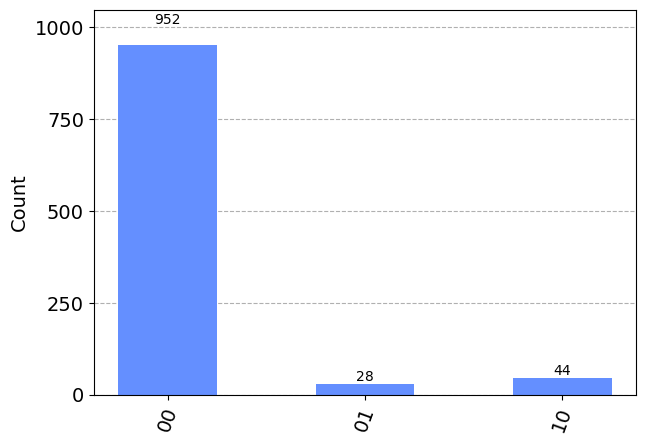

1.0


In [10]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(hhl, backend, shots=1024)
result = job.result()
counts = result.get_counts(hhl)
display(plot_histogram(counts))
print(get_psuccess(counts))

And on the real hardware, whose chip is structured in the following way:

![NAIROBI](ibm_nairobi_chip.png)

In [14]:
#provider = IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibm_nairobi')

print("Circuit before transpiling")
display(hhl.draw())

mapped_circuit = transpile(hhl, backend=backend)

print("Circuit after transpiling")
display(mapped_circuit.draw())

NameError: name 'provider' is not defined

In [12]:
qobj = assemble(mapped_circuit, backend=backend, shots=100)
job = backend.run(qobj)
result = job.result()
counts = result.get_counts(hhl)
display(plot_histogram(counts))
print(get_psuccess(counts))

NameError: name 'mapped_circuit' is not defined

# References
[1] Ganguly, S. (2021). Quantum Machine Learning: An Applied Approach. Apress.

[2] J. Pan, Y. Cao, X. Yao, Z. Li, C. Ju, H. Chen, X. Peng, S. Kais, and J. Du. (2014). [Experimental realization of quantum algorithm for solving linear systems of equations](https://arxiv.org/abs/1302.1946). *Physical Review Letters* 89:022313. <a id='1'></a>
